In [78]:
import pickle
import sys
import csv
import random
sys.path.append(r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project')
from execute_remote_scripts import *
# from Processing_Data.downsampling import *
%matplotlib widget
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde
%load_ext autoreload
%autoreload 2
# from Server_Scripts.remote_processing_csv import *
from Processing_Data.EDA import *

from Processing_Data.create_labels import * # To load the data in dictionaries

# Enable LaTeX rendering
plt.rcParams.update({
    "text.usetex": False, 
    "font.family": "serif"
})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Loading classified shots in dictionaries
base_path = r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\CSV_test'
re_autom_path = r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Data\automatic_RE_numbers.csv'
re_valid_path = r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Data\validated_RE_numbers.csv'

dataframes, RE_autom, RE_valid, NO_RE_probably, features = load_and_process_data(
    base_path, re_autom_path, re_valid_path, check_nans_infs
)

# Print results
print(f"Loaded {len(dataframes)} shots.")
print(f"Automatic RE shots: {len(RE_autom)}")
print(f"Validated RE shots: {len(RE_valid)}")
print(f"Probably NO RE shots: {len(NO_RE_probably)}")
print(f"Features: {features}")

DataFrame 84162: NaNs = 832, Infs = 0
DataFrame 86646: NaNs = 232, Infs = 0
DataFrame 95732: NaNs = 1408, Infs = 0
DataFrame 95768: NaNs = 1791, Infs = 0
DataFrame 98150: NaNs = 20, Infs = 0
DataFrame 98169: NaNs = 700, Infs = 0
DataFrame 98176: NaNs = 2719, Infs = 0
DataFrame 99034: NaNs = 272, Infs = 0
Dropped DataFrames: [84162, 86646, 95732, 95768, 98150, 98169, 98176, 99034]
Loaded 16 shots.
Automatic RE shots: 6
Validated RE shots: 6
Probably NO RE shots: 10
Features: ['SSXcore', 'IPLA', 'DAO_EDG7', 'WMHD', 'RNT', 'DAI_EDG7']


In [65]:
random.seed(42) # So that we always work with the same ones.
random_50_re = random.sample(RE_valid, 5)  # Ensures no duplicates

In [ ]:
# #In case we need to recreate the dictionary
# RE_lifetimes = {}

# np.savez(r"C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Processing_Data\RE_lifetime.npz", **RE_lifetimes)


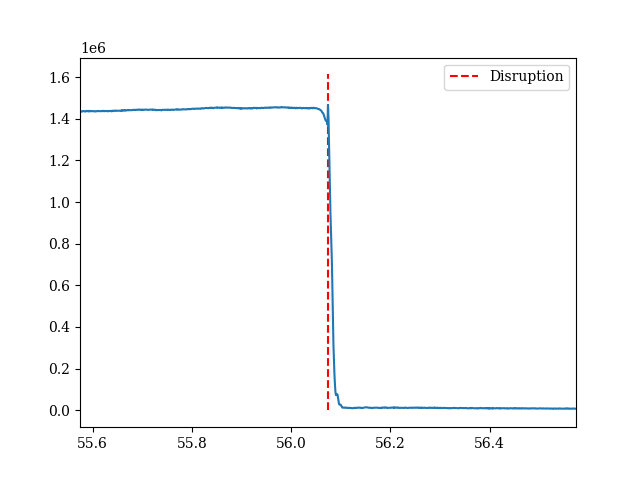

In [71]:
# Shot that is currently processed
k = 0
shot_nr = 98173# random_50_re[k]

# Load the file and plot it
base_path_re = r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\CSV_test'
file_path = os.path.join(base_path_re, 'JETno' + str(shot_nr)+'.csv')
data = pd.read_csv(file_path)
plt.close()

# Find the first index where time is greater than the starting time + 1
first_index = np.argmax(data['time'] > data['time'][0] + 1)  

# Plot vertical line at this point
plt.vlines(data['time'][first_index], ymin=0, ymax=-data['IPLA'].min()*1.1, color='r', linestyle='dashed', label='Disruption')

plt.plot(data['time'], -data['IPLA'])

# Show the plot
plt.legend()
plt.xlim(data['time'][first_index]-0.5, data['time'][first_index]+0.5)
plt.show()

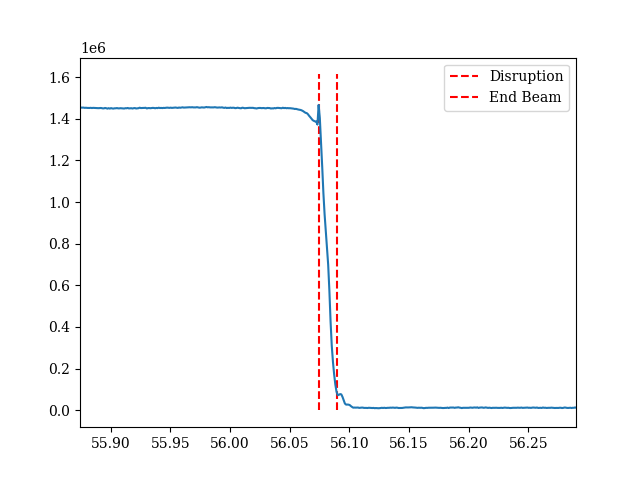

In [74]:
# Set time that is to be written as end of the beam time
end_beam = 56.09

# Load the dictionary
RE_lifetimes = np.load(r"C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Processing_Data\RE_lifetime.npz")
RE_lifetimes = {key: RE_lifetimes[key] for key in RE_lifetimes.files}
# Set the new value and save
RE_lifetimes[f'{shot_nr}'] = np.array([data['time'][first_index], end_beam])
np.savez(r"C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Processing_Data\RE_lifetime.npz", **RE_lifetimes)

# Plot to verify
plt.close()
plt.vlines(data['time'][first_index], ymin=0, ymax=-data['IPLA'].min()*1.1, color='r', linestyle='dashed', label='Disruption')
plt.vlines(end_beam, ymin=0, ymax=-data['IPLA'].min()*1.1, color='r', linestyle='dashed', label='End Beam')
plt.plot(data['time'], -data['IPLA'])

# Show the plot
plt.legend()
plt.xlim(data['time'][first_index]-0.2, end_beam+0.2)
plt.show()

In [75]:
RE_lifetimes

{'91076': array([60.0238, 60.11  ]),
 '98088': array([56.5092, 56.53  ]),
 '97085': array([53.8901, 53.91  ]),
 '98173': array([56.07429912, 56.09      ]),
 '97081': array([51.8327, 51.86  ])}

## Creating targets from beam durations

In [53]:
# Load csv file from RE_lifetimes dictionary keys
targets = {}

for shot_nr in RE_lifetimes.keys():
    file_path = os.path.join(base_path_re, 'JETno' + str(shot_nr)+'.csv')
    data = pd.read_csv(file_path)
    time = data['time'] # Time array of the current shot
    target = np.zeros(len(time)) # Will be target, timesteps that are within the beam lifetime will be set to 1
    lifetimes = RE_lifetimes[shot_nr] # Loading the lifetime window
    target[(time>lifetimes[0]) & (time<lifetimes[1])]=1# Setting the target within the runaway range to 1
    targets[shot_nr] = target

In [32]:
# Create array with zeros of the length of the time array, and fill the ones that are within the runaway beam timescale with one

In [54]:
# Load CSV file and create target arrays for all shots

targets = {
    shot_nr: (
        lambda data, lifetimes: np.where(
            (data['time'].values > lifetimes[0]) & (data['time'].values < lifetimes[1]), 
            1, 0
        )
    )(pd.read_csv(os.path.join(base_path_re, f'JETno{shot_nr}.csv')), RE_lifetimes[shot_nr])
    for shot_nr in RE_lifetimes.keys()
}